<a href="https://colab.research.google.com/github/stun99/AIML/blob/main/challenge13_SAXPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
%%writefile cuda.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <math.h>       // For fmax, fabs
#include <stdlib.h>     // For malloc, free

__global__
void saxpy(int n, float a, float *x, float *y)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < n) y[i] = a * x[i] + y[i];
}

int main(void)
{
    int start_power = 15;
    int end_power = 25;

    // Arrays to store results
    float total_times[11];    // Total time including malloc, copy, kernel
    float kernel_times[11];   // Kernel time only

    for (int p = start_power; p <= end_power; p++) {
        int idx = p - start_power;
        int N = 1 << p;
        printf("Running for N = %d\n", N);

        float *x, *y, *d_x, *d_y;
        x = (float*)malloc(N * sizeof(float));
        y = (float*)malloc(N * sizeof(float));

        for (int i = 0; i < N; i++) {
            x[i] = 1.0f;
            y[i] = 2.0f;
        }

        cudaEvent_t start_total, stop_total, start_kernel, stop_kernel;
        cudaEventCreate(&start_total);
        cudaEventCreate(&stop_total);
        cudaEventCreate(&start_kernel);
        cudaEventCreate(&stop_kernel);

        cudaEventRecord(start_total);

        cudaMalloc(&d_x, N * sizeof(float));
        cudaMalloc(&d_y, N * sizeof(float));
        cudaMemcpy(d_x, x, N * sizeof(float), cudaMemcpyHostToDevice);
        cudaMemcpy(d_y, y, N * sizeof(float), cudaMemcpyHostToDevice);

        // Launch kernel and measure kernel time
        cudaEventRecord(start_kernel);
        saxpy<<<(N + 255) / 256, 256>>>(N, 2.0f, d_x, d_y);
        cudaEventRecord(stop_kernel);

        cudaMemcpy(y, d_y, N * sizeof(float), cudaMemcpyDeviceToHost);

        cudaEventRecord(stop_total);
        cudaEventSynchronize(stop_total);
        cudaEventSynchronize(stop_kernel);

        float total_msec = 0.0f;
        float kernel_msec = 0.0f;
        cudaEventElapsedTime(&total_msec, start_total, stop_total);
        cudaEventElapsedTime(&kernel_msec, start_kernel, stop_kernel);

        total_times[idx] = total_msec;
        kernel_times[idx] = kernel_msec;

        float maxError = 0.0f;
        for (int i = 0; i < N; i++)
            maxError = fmax(maxError, fabs(y[i] - 4.0f));
        printf("Max error: %f\n", maxError);
        printf("Total time: %.3f ms, Kernel time: %.3f ms\n\n", total_msec, kernel_msec);

        cudaFree(d_x);
        cudaFree(d_y);
        free(x);
        free(y);

        cudaEventDestroy(start_total);
        cudaEventDestroy(stop_total);
        cudaEventDestroy(start_kernel);
        cudaEventDestroy(stop_kernel);
    }

    // Save data to plot later
    FILE *fp = fopen("timing_data.csv", "w");
    fprintf(fp, "N,TotalTime_ms,KernelTime_ms\n");
    for (int i = 0; i <= (end_power - start_power); i++) {
        int N = 1 << (i + start_power);
        fprintf(fp, "%d,%.5f,%.5f\n", N, total_times[i], kernel_times[i]);
    }
    fclose(fp);

    printf("Timing data saved to timing_data.csv\n");

    return 0;
}


Overwriting cuda.cu


In [6]:
!nvcc cuda.cu -o cuda_exec


In [7]:
!./cuda_exec


Running for N = 32768
Max error: 2.000000
Total time: 41.534 ms, Kernel time: 40.265 ms

Running for N = 65536
Max error: 2.000000
Total time: 0.461 ms, Kernel time: 0.003 ms

Running for N = 131072
Max error: 2.000000
Total time: 0.630 ms, Kernel time: 0.003 ms

Running for N = 262144
Max error: 2.000000
Total time: 1.139 ms, Kernel time: 0.003 ms

Running for N = 524288
Max error: 2.000000
Total time: 1.722 ms, Kernel time: 0.003 ms

Running for N = 1048576
Max error: 2.000000
Total time: 2.898 ms, Kernel time: 0.003 ms

Running for N = 2097152
Max error: 2.000000
Total time: 6.008 ms, Kernel time: 0.003 ms

Running for N = 4194304
Max error: 2.000000
Total time: 12.041 ms, Kernel time: 0.003 ms

Running for N = 8388608
Max error: 2.000000
Total time: 22.356 ms, Kernel time: 0.003 ms

Running for N = 16777216
Max error: 2.000000
Total time: 44.415 ms, Kernel time: 0.003 ms

Running for N = 33554432
Max error: 2.000000
Total time: 96.011 ms, Kernel time: 0.003 ms

Timing data saved to

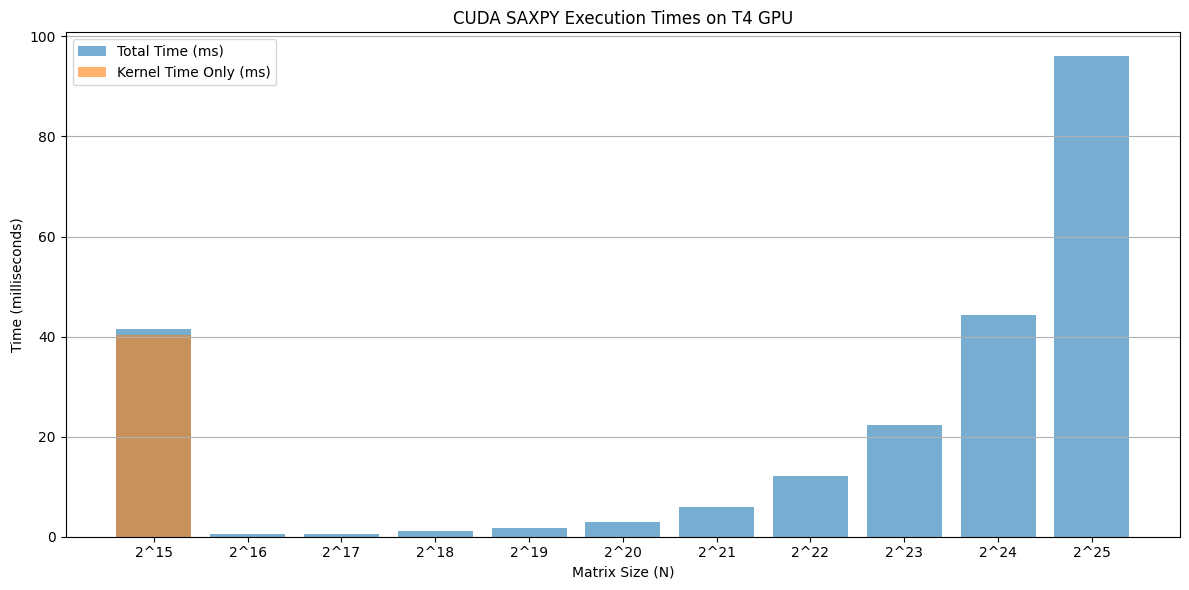

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv("timing_data.csv")
N = data["N"]
total_time = data["TotalTime_ms"]
kernel_time = data["KernelTime_ms"]

plt.figure(figsize=(12,6))
plt.bar(range(len(N)), total_time, label="Total Time (ms)", alpha=0.6)
plt.bar(range(len(N)), kernel_time, label="Kernel Time Only (ms)", alpha=0.6)
plt.xticks(range(len(N)), [f"2^{int(n).bit_length()-1}" for n in N])
plt.xlabel("Matrix Size (N)")
plt.ylabel("Time (milliseconds)")
plt.title("CUDA SAXPY Execution Times on T4 GPU")
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()